# Linear and Logistic Regression in Tensorflow

## Linear Regression in Tensorflow
-----
    Dataset Description:
    Name: Fire and Theft in Chicago
    X = fires per 1000 housing units
    Y = thefts per 1000 population

    within the same Zip code in the Chicago metro area
    Total number of Zip code areas: 42
    
    Solution:
    First, assume that the relationship between the number of fires and thefts are linear:
    Y = wX + b


w=1.7183813 b=15.789157
42
loss=25.375277


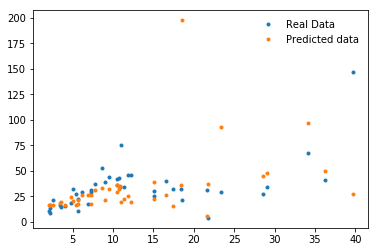

In [43]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import xlrd

DATA_FILE = "data/slr05.xls"

# Step 1: read in data from the .xls file
book = xlrd.open_workbook(DATA_FILE, encoding_override="utf-8")
sheet = book.sheet_by_index(0)
data = np.asarray([sheet.row_values(i) for i in range(1, sheet.nrows)])
n_samples = sheet.nrows - 1

# Step 2: create placeholders for input X (number of fire) and label Y (number of theft)
X = tf.placeholder(tf.float32, name="X")
Y = tf.placeholder(tf.float32, name="Y")

# Step 3: create weight and bias, initialized to 0
w = tf.Variable(0.0, name="weights")
b = tf.Variable(0.0, name="bias")

# Step 4: construct model to predict Y (number of theft) from the number of fire
Y_predicted = X * w + b

# Step 5: use the square error as the loss function
loss = tf.square(Y - Y_predicted, name="loss")

# Step 6: using gradient descent with learning rate of 0.01 to minimize loss
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss)

y_r = []
with tf.Session() as sess:
    # Step 7: initialize the necessary variables, in this case, w and b
    sess.run(tf.global_variables_initializer())
    
    # Step 8: train the model
    for i in range(100): # run 100 epochs
        for x, y in data:
            if i == 99:
                y_r.append(sess.run(Y_predicted, feed_dict={X: x, Y:y}))
            # Session runs train_op to minimize loss
            sess.run(optimizer, feed_dict={X: x, Y:y})
    
           
    # Step 9: output the values of w and b
    w_value, b_value = sess.run([w, b])
    print("w=%r b=%r" % (w_value, b_value))
    
    # plot
    print(len(y_r))
    loss_r = sess.run(loss, feed_dict={X: x, Y:y})
    print("loss=%r" % loss_r)
    
    plt.figure('linear regression')
    #print("x=%r " % (data[:,0]))
    plt.plot(data[:,0], data[:,1], '.', label="Real Data")
    plt.plot(data[:,0], y_r, '.', label="Predicted data")
    plt.legend(loc='upper right', frameon=False)